In [82]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import rasterio
from PIL import Image

import requests
import zipfile
from pathlib import Path

from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.0.0+cpu'

In [83]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [84]:
# Setup path to data folder
data_path = Path("./data")
image_path = data_path / "Euro_MS"

In [85]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [86]:
print (image_path)

data\Euro_MS


In [87]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\Euro_MS'.
There are 10 directories and 0 images in 'data\Euro_MS\test'.
There are 0 directories and 600 images in 'data\Euro_MS\test\AnnualCrop'.
There are 0 directories and 600 images in 'data\Euro_MS\test\Forest'.
There are 0 directories and 600 images in 'data\Euro_MS\test\HerbaceousVegetation'.
There are 0 directories and 500 images in 'data\Euro_MS\test\Highway'.
There are 0 directories and 500 images in 'data\Euro_MS\test\Industrial'.
There are 0 directories and 400 images in 'data\Euro_MS\test\Pasture'.
There are 0 directories and 500 images in 'data\Euro_MS\test\PermanentCrop'.
There are 0 directories and 600 images in 'data\Euro_MS\test\Residential'.
There are 0 directories and 500 images in 'data\Euro_MS\test\River'.
There are 0 directories and 600 images in 'data\Euro_MS\test\SeaLake'.
There are 10 directories and 0 images in 'data\Euro_MS\train'.
There are 0 directories and 2400 images in 'data\Euro_MS\train\AnnualCrop'.
There a

In [88]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/Euro_MS/train'), WindowsPath('data/Euro_MS/test'))

In [89]:
# Write transform for image
data_transform = transforms.Compose([
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [90]:
class CustomImageFolder_Size(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes()
        self.samples = self._make_dataset()

    def _find_classes(self):
        classes = [d.name for d in os.scandir(self.root_dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def _make_dataset(self):
        images = []
        for target_class in sorted(self.class_to_idx.keys()):
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(self.root_dir, target_class)
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):     
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, class_index)
                    images.append(item)
        return images

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        with rasterio.open(path) as f:
            img_dat = f.read()
            img = np.asarray(img_dat,dtype=np.float32)
        if self.transform is not None:
            img = self.transform(img)
            img = img.permute(1,0,2)                      # to get [height,width,colour_channel as op]
        return img, target
    
    def set_samples(self, num_samples):
        self.samples = self.samples[:num_samples]

In [91]:
# Use ImageFolder to create dataset(s)

# presently testing out a data set for customized size

train_data = CustomImageFolder_Size(root_dir=train_dir, # target folder of images
                                  transform=data_transform,
                                  ) # transforms to perform on data (images)
                        

test_data = CustomImageFolder_Size(root_dir=test_dir, 
                                 transform=data_transform,)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Test data:


In [92]:
class_names = train_data.classes
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [93]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [94]:
class_dict.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [95]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              #num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             #num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x200ff0175e0>,
 <torch.utils.data.dataloader.DataLoader at 0x20082b1dc90>)

In [96]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 13, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [97]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion



In [98]:
def test_step_2(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    y_true , y_pred = [],[]
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)
            y_true.append(y)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            y_pred.append(test_pred_labels)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
            
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc, y_true, y_pred

In [99]:
model_0 = torch.load('./models/EuroSAT_M1_H39')

In [100]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 13, 64, 64]) 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 39, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 39, 64, 64]           4,602
│    └─ReLU: 2-2                         [1, 39, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 39, 64, 64]           13,728
│    └─ReLU: 2-4                         [1, 39, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 39, 32, 32]           --
├─Sequential: 1-2                        [1, 39, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 39, 32, 32]           13,728
│    └─ReLU: 2-7                         [1, 39, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 39, 32, 32]           13,728
│    └─ReLU: 2-9                         [1, 39, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 39, 16, 16]           --


In [101]:
loss_fn = nn.CrossEntropyLoss()
test_l, test_ac, y_true, y_pred= test_step_2(model=model_0,
          dataloader = test_dataloader,
          loss_fn = loss_fn)

print("Test loss : ",test_l," | Test accuracy : ",test_ac)

Test loss :  0.40496902249754113  | Test accuracy :  0.9048148148148148


In [102]:
y_pred[2]

tensor([0])

In [130]:
import torch

def confusion_matrix(preds, labels, num_classes):
    """
    Calculates the confusion matrix given predictions and labels.

    Args:
        preds (torch.Tensor): Predicted labels (usually after applying argmax to model output).
        labels (torch.Tensor): True labels.
        num_classes (int): Number of classes in the dataset.

    Returns:
        torch.Tensor: Confusion matrix of shape (num_classes, num_classes).
    """

    # Initialize confusion matrix with zeros
    matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)

    # Populate the confusion matrix
    #for A in (labels, preds):
    #    matrix[int(A[0])][ int(A[1])] += 1
        
    for i in range(0,len(y_true),1):
        matrix[int(y_true[i])][int(y_pred[i])] +=1

    return matrix

In [131]:
mat = confusion_matrix(y_pred,y_true,len(class_dict))
print(mat)

tensor([[528,   1,  18,  10,   0,  20,  23,   0,   0,   0],
        [  0, 585,   2,   1,   0,  12,   0,   0,   0,   0],
        [  3,   3, 566,   8,   0,  13,   7,   0,   0,   0],
        [  3,   3,  19, 413,  22,  25,  10,   0,   4,   1],
        [  0,   0,   0,  17, 479,   0,   0,   4,   0,   0],
        [  1,  10,  19,   2,   0, 368,   0,   0,   0,   0],
        [ 13,   2,  23,  12,   1,  19, 429,   0,   1,   0],
        [  0,   0,  11,  49,  59,   4,   8, 469,   0,   0],
        [  0,   1,   9,  14,   5,   5,   0,   0, 449,  17],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 600]])


In [123]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [133]:

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred,10)

In [136]:
cm2 = np.asarray(cm)

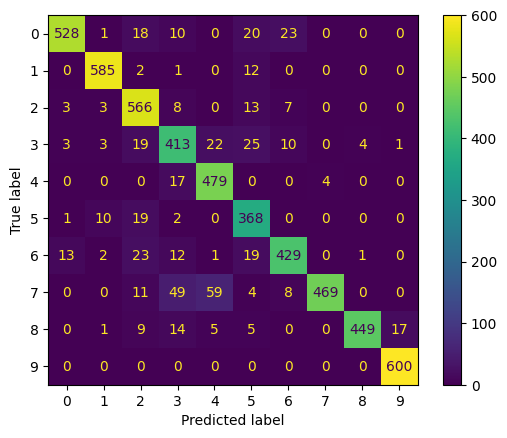

<Figure size 600x600 with 0 Axes>

In [143]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.show()